# 02 - Interpreting the Regressions

In this notebook you will find the code used to calculate the Median Ranks as well as to plot the plots regarding the SHAP values.

This is done for only one factor, as defined from the previous notebook.

In [1]:
%matplotlib inline

import pickle
import numpy as np
import pandas as pd

import shap

In [2]:
# Getting the results from previous notebook
res = pickle.load( open( "dic_all_FAC1_results.pkl", "rb" ) )

In [3]:
# Getting the feature's names, removing the "fs_" in the beginning
columns = pd.read_csv("../example_data/node_wise_features.csv").set_index("Subjects").columns.values
myfunc = lambda x : x.split("fs_")[1]
columns = np.array([myfunc(x) for x in columns])

## Overall results

Showing the mean and the standard deviation for each metric

In [4]:
fac_to_predict = 'FAC1'

print("Overall results for Factor 1:")

for score in ['r2', 'mae', 'mse']:
    scores = []
    # Going over the 5 folds
    for i in range(5):
        scores.append(res['split'+str(i)][score])
    print("\tMean of %s: %.3f (%.3f)" % (score, np.mean(scores), np.std(scores)))

coef = []    
for i in range(5):
    # Going over the 5 folds
    val = res['split'+str(i)]['pearson_r']
    coef.append(val[0])

print("\tMean of pearson-r: %.3f (%.3f)" % (np.mean(coef), np.std(coef)))

Overall results for Factor 1:
	Mean of r2: -0.021 (0.023)
	Mean of mae: 2.590 (0.100)
	Mean of mse: 8.835 (0.514)
	Mean of pearson-r: -0.005 (0.043)


## Using the SHAP package

This will plot the SHAP values, in each fold, for the 15 most important features

In [5]:
# It calculated the Median Absolute Deviation
def median_absolute_deviation(arr):
    return np.median(np.abs(arr - np.median(arr)))

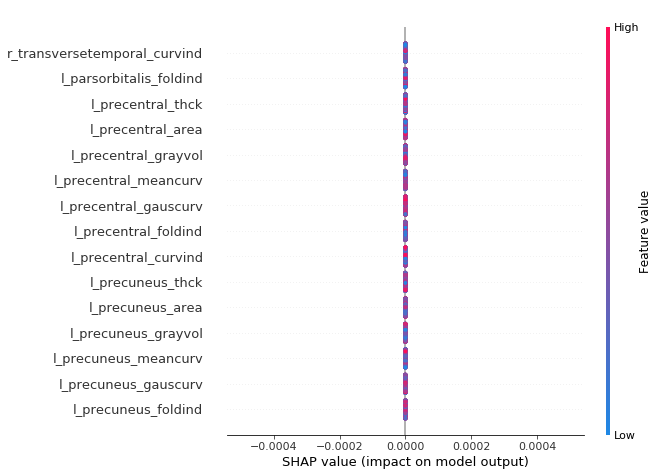

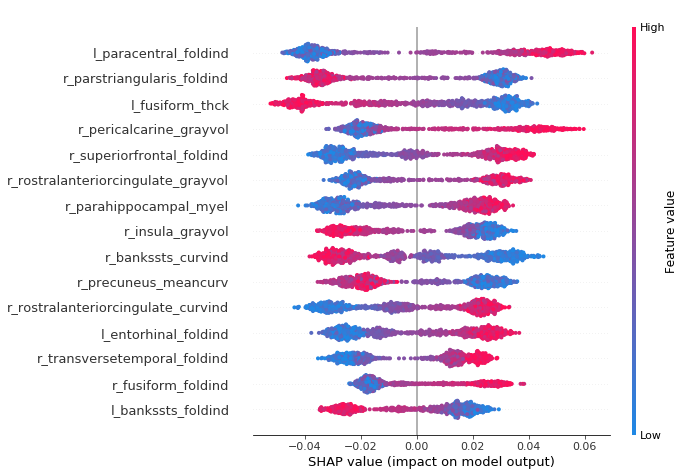

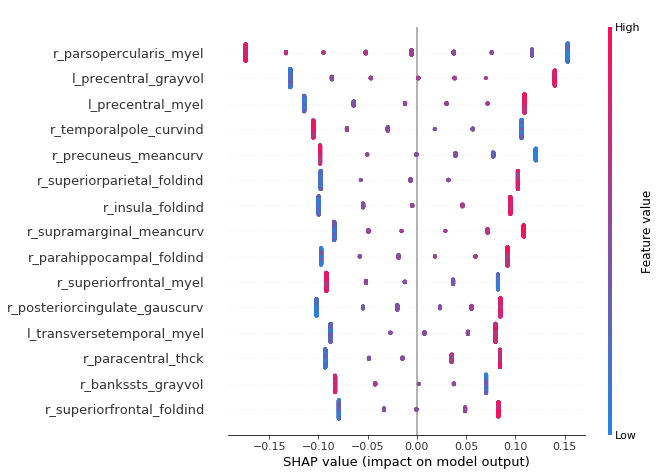

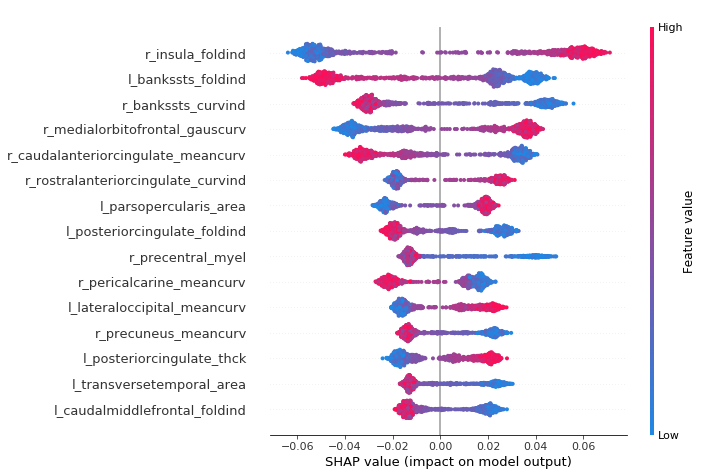

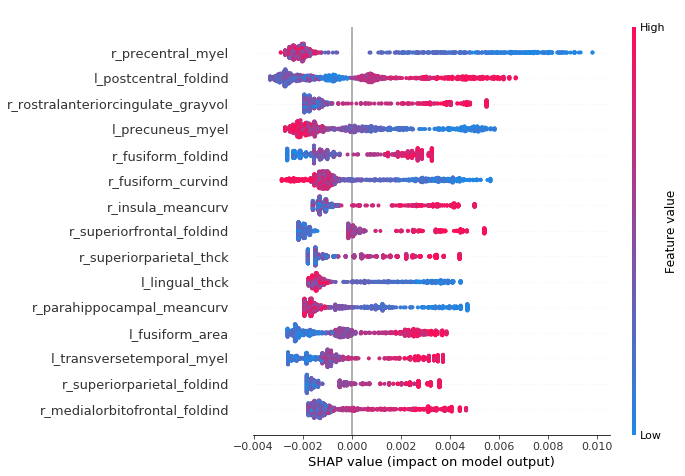

In [6]:
# Getting the original data (X)
X = res['X']

# Dictionary where the ranks of each feature will be, across the 5 folds
rank_dic = {}

# Going over all the 5 outer folds
for i in range(5):
    # clf_obj has the results of the inner folder runs
    clf = res['split'+str(i)]['clf_obj']
    selected_f = res['split'+str(i)]['kbests']
    # filt_features will have the 450 features that were selected using Mutual Information
    filt_features = columns[selected_f]

    # Getting the trained xgboost model
    model_x = clf.best_estimator_.named_steps['xgb']
    # TreeExplainer is a class that will interpret the xgboost model
    explainer = shap.TreeExplainer(model_x)

    # X2 is X with the 450 best selected features
    #   columns need to be the same as xgboost object in order to run in shap
    X2 = pd.DataFrame(X.iloc[:, selected_f].values, 
             index=X.index,
             columns=model_x.get_booster().feature_names)

    # Plotting the shap values in the fold but passing "filt_features" to have the proper features' names
    shap_values = explainer.shap_values(X2)
    shap.summary_plot(shap_values, X2, max_display=15, feature_names=filt_features)

    # Updating rank_dic to have the different ranks of each feature
    feature_order = np.argsort(-np.sum(np.abs(shap_values), axis=0))
    for i, elem in enumerate(filt_features[feature_order]):
        if elem in rank_dic:
            rank_dic[elem].append(i+1)
        else:
            rank_dic[elem] = [i+1]



## Showing the median ranks and MADs

In [7]:
# final_rank_dic will have median rank and MAD of each brain feature
final_rank_dic = {}
for key, elem in rank_dic.items():
    if len(elem) >= 4: # If that feature appeared in at least 4 outer folds is more consistent
        final_rank_dic[key] = [np.median(elem), median_absolute_deviation(elem)]

# Transforming final_rank_dic to a DataFrame to be easier to see the 20 features with the best mean rank
final_rank = pd.DataFrame(final_rank_dic).transpose()
final_rank.columns = ["Mean Rank", "MAD"]
final_rank.sort_values(by=['Mean Rank']).iloc[0:20,:]

,Mean Rank,MAD
r_precuneus_meancurv,12.0,7.0
r_superiorfrontal_foldind,15.0,10.0
l_transversetemporal_myel,16.5,4.0
r_bankssts_curvind,19.0,16.0
r_rostralanteriorcingulate_grayvol,22.0,19.0
l_bankssts_foldind,25.0,23.0
r_parahippocampal_meancurv,28.0,3.0
r_rostralanteriorcingulate_curvind,30.0,24.0
r_precentral_myel,32.0,31.0
r_precentral_gauscurv,33.0,12.0
